# Benchmarking interactive segmentation tools: With ClickSeg

Here we will benchmark ClickSeg. Due its similarity with RITM codebase, several functions were reused


Not made to work with Google Collab. If you run it on VS Code, assert that you have the ipykernel and have the right kernel selected (a venv, in my case :) ) ------>  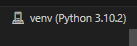

In [1]:
# run this cell only once

import os
import sys


# activate virtual environment. If you don't have one, create it first.
# !venv\Scripts\activate

# Clone only one time the ritm repo. If you already have it, comment this line.

! git clone https://github.com/XavierCHEN34/ClickSEG.git

os.chdir('FocalClick') 
sys.path.insert(0, '..') # allow you to import modules from ritm repo
!pip install -r requirements.txt
!pip install torch torchvision torchaudio cudatoolkit=11.3 -f https://download.pytorch.org/whl/torch_stable.html

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
from isegm.inference.predictors import get_predictor
from isegm.inference.clicker import Click, Clicker
from isegm.utils import vis, exp
from isegm.inference import utils
cfg = exp.load_config_file('config.yml', return_edict=True)

## Here we load the model. You can use any model from the ritm repo.
weights_path = 'segformer-b3s2.pth'
MODEL_THRESH = 0.50

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, weights_path)
model = utils.load_is_model(checkpoint_path, device)

# For our purposes, we don't need to use the BRS mode.
brs_mode = 'NoBRS'
clickseg_predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

c:\Users\Vítor\Documents\GitHub\vdj_grape_annotation\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ImageAnnotations is the class that will help us to load the annotations from diverse formats and work simultaneously with multiple annotations. 
# Some caracteristics of the class:
# - It can load annotations from Supervisely*, wgisd and can easly be extended to other formats.
# - It can load multiple annotations from different formats

from modules.dataset import ImageAnnotations
from copy import copy

def create_clicker_from_annotations(annotation:ImageAnnotations, bbox_id:int, include_aux=True):
    """Create a clicker object from an annotation object."""
    clicker = Clicker()
    bbox = next(box for box in annotation.box_annotations if box['id'] == annotation.box_annotations[bbox_id]['id'])
    
    for point_id in bbox['points_inside']:
        point = next(p for p in annotation.point_annotations if p['id'] == point_id)
        aux_points = []
        if point['is_aux']:
            aux_points.append(point)
        else:
            click = Click(is_positive=point['is_positive'], coords=[point['coord_bb'][1], point['coord_bb'][0]])
            clicker.add_click(click)
        if include_aux and aux_points:
            for aux_point in aux_points:
                click = Click(is_positive=aux_point['is_positive'], coords=[aux_point['coord_bb'][1], aux_point['coord_bb'][0]])
                clicker.add_click(click)
    return clicker

def get_ritm_prediction(ritm_predictor, annotations:ImageAnnotations, jsons_folder='../datasets/supervisely_annotations/'
                        , wgisd_folder='../datasets/wgisd_annotations/', include_aux=True, wgisd_n_points=3):
    """Finally, we can get the RITM prediction for a given image."""
    annotations.load_image('../datasets/images/' + annotations.image_name)
    ritm_predictor = copy(ritm_predictor) # If your wanna make sure one prediction doesn't affect the other
    if annotations.image_name.startswith('DSC'):
        annotations.read_supervisely(jsons_folder + annotations.image_name + '.json')
        annotations.validate_supervisely_annotations()
    elif annotations.image_name.startswith('SYH') or annotations.image_name.startswith('CSV'):
        sufx = f'-{wgisd_n_points}point' if wgisd_n_points==1 else f'-{wgisd_n_points}points'
        annotations.read_wgisd(wgisd_folder + annotations.image_name.replace('.jpg', '.npz'), excel_sufx=sufx)
    
    ritm_predictions = []
    for id, bb in enumerate(annotations.box_annotations):
        print(bb)
        image = annotations.bb_image_2_np(bb)
        ritm_predictor.set_input_image(image)
        clicker = create_clicker_from_annotations(annotations, id, include_aux=include_aux)
        pred = ritm_predictor.get_prediction(clicker)
        ritm_predictions.append(pred)
    return ritm_predictions, clicker

WGisd annotations loaded.
{'coords': [[1051, 706], [1317, 1228]], 'id': 0, 'points_inside': [0, 1, 2]}
None
{'coords': [[1483, 91], [1764, 516]], 'id': 1, 'points_inside': [3, 4, 5]}
None
{'coords': [[202, 262], [530, 701]], 'id': 2, 'points_inside': [6, 7, 8]}
None
{'coords': [[1451, 468], [1845, 1043]], 'id': 3, 'points_inside': [9, 10, 11]}
None
{'coords': [[1280, 531], [1534, 998]], 'id': 4, 'points_inside': [12, 13, 14]}
None
{'coords': [[329, 616], [587, 1068]], 'id': 5, 'points_inside': [15, 16, 17]}
None
{'coords': [[551, 788], [821, 1123]], 'id': 6, 'points_inside': [18, 19, 20]}
None
{'coords': [[606, 542], [895, 794]], 'id': 7, 'points_inside': [21, 22, 23]}
None


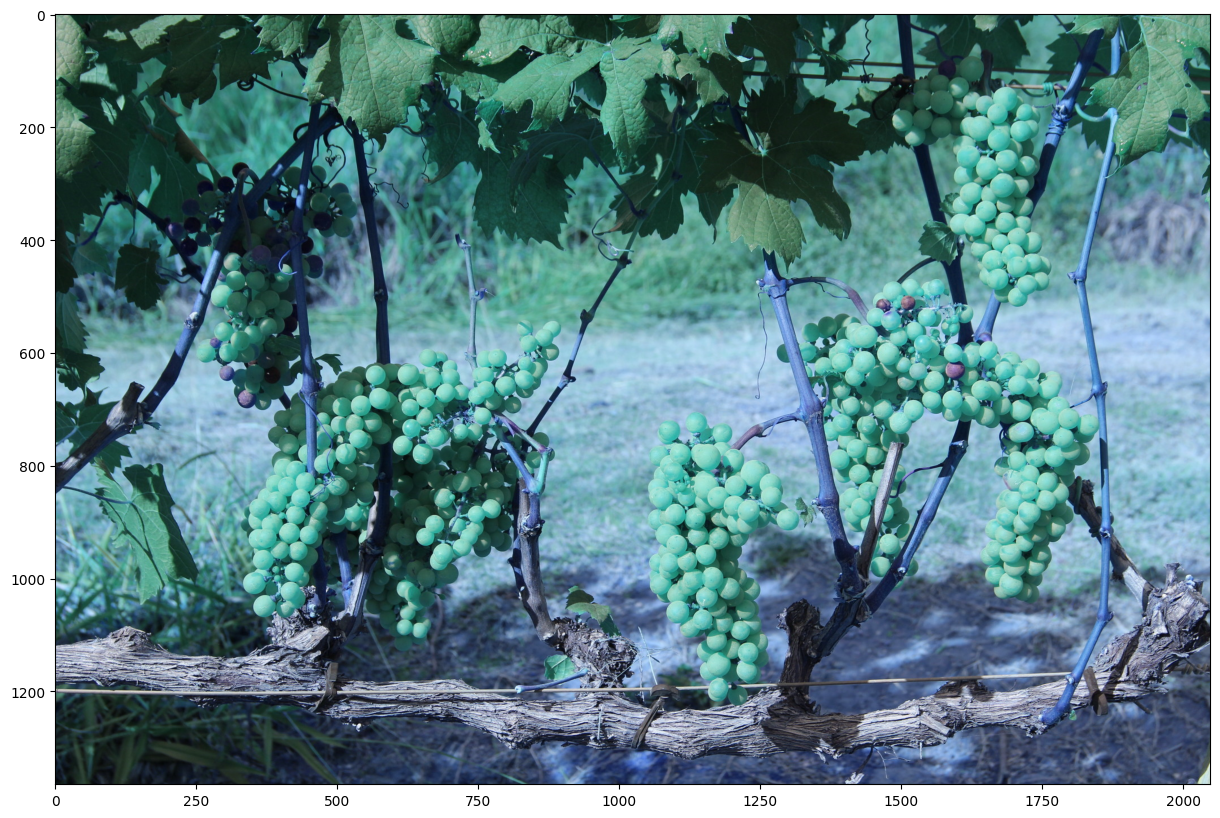

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# jsons_folder = '../experiment/1-converting-labels-and-croping-images/' experiment\2-organize-datasets\images\DSC_0109.JPG
# jpg_file = 'DSC_0152.JPG'
jpg_file = 'CSV_1865.jpg'

# Enable predictor
anot = ImageAnnotations(jpg_file)
ritm_predictions, clicker = get_ritm_prediction(clickseg_predictor, anot, include_aux=True)

prediction_label = f'clickseg_{brs_mode}_3_points' # file suffix and predictions dictionary key
anot.reconstruct_prediction_mask(ritm_predictions, prediction_label)
plt.rcParams["figure.figsize"] = (30,10)
plt.imshow(anot.image_pred[prediction_label] >= 0.5)
plt.imshow(anot.image, cmap='gray')

In [7]:
## Time to iterate over all images and save the predictions

all_jpgs = os.listdir('../datasets/images/')
wgisd_csv = [img for img in all_jpgs if img.startswith('CSV')]
wgisd_syh = [img for img in all_jpgs if img.startswith('SYH')]
supervisely = [img for img in all_jpgs if img.startswith('DSC')]

def save_ritm_predictions(imgs, output_folder, ritm_predictor, prediction_name, include_aux=True,
                                                    jsons_folder='../datasets/supervisely_annotations/',
                                                        wgisd_folder='../datasets/wgisd_annotations/', wgisd_n_points=None):
    for img in imgs:
        anot = ImageAnnotations(img)
        print ('Processing', anot.image_name)
        ritm_predictions, clicker = get_ritm_prediction(ritm_predictor, anot, include_aux=include_aux, wgisd_n_points=wgisd_n_points)
        anot.reconstruct_prediction_mask(ritm_predictions, prediction_name)
        dados = { 
                    'full': (anot.image_pred[prediction_name] > MODEL_THRESH).astype(np.uint8),
                    'bbs': {i:(pred > MODEL_THRESH).astype(np.uint8) for i, pred in enumerate(ritm_predictions )}
        }
        # dados = (anot.image_pred[prediction_name] > 0.45).astype(np.int8)
        np.savez_compressed(f'{output_folder}/{anot.image_name}_{prediction_name}.npz', **dados, allow_pickle=True)
        print(f'{anot.image_name} annotation saved.')


### Time to configure and run the loop

In [14]:
import time
start = time.time()

# Change list of images to process as you need, project for 2 distinct tests
save_ritm_predictions(supervisely, '../datasets/clickseg_predictions/', clickseg_predictor, f'clickseg_{brs_mode}_1_points', include_aux=False, wgisd_n_points=1)
print('Tempo 1 ponto:', time.time() - start)
save_ritm_predictions(supervisely, '../datasets/clickseg_predictions/', clickseg_predictor, f'clickseg_{brs_mode}_3_points', include_aux=True, wgisd_n_points=3)
print('Tempo 3 pontos:', time.time() - start)

Processing DSC_0109.JPG
{'class': 'caixa', 'coords': [[616, 2095], [1124, 2410]], 'id': 0, 'points_inside': [59, 60, 66]}
{'class': 'caixa', 'coords': [[1660, 2207], [2148, 2453]], 'id': 1, 'points_inside': [30, 31, 32]}
{'class': 'caixa', 'coords': [[1511, 1790], [1894, 2209]], 'id': 2, 'points_inside': [27, 28, 29]}
{'class': 'caixa', 'coords': [[1878, 1764], [2148, 2220]], 'id': 3, 'points_inside': [24, 25, 26]}
{'class': 'caixa', 'coords': [[2036, 2412], [2459, 2722]], 'id': 4, 'points_inside': [4, 5, 6]}
{'class': 'caixa', 'coords': [[2143, 1939], [2532, 2474]], 'id': 5, 'points_inside': [21, 22, 23]}
{'class': 'caixa', 'coords': [[1954, 2716], [2444, 3044]], 'id': 6, 'points_inside': [1, 2, 3]}
{'class': 'caixa', 'coords': [[2427, 2393], [2725, 2836]], 'id': 7, 'points_inside': [15, 16, 17]}
{'class': 'caixa', 'coords': [[2520, 1931], [2992, 2390]], 'id': 8, 'points_inside': [18, 19, 20]}
{'class': 'caixa', 'coords': [[2702, 2378], [3036, 2974]], 'id': 9, 'points_inside': [12, 13

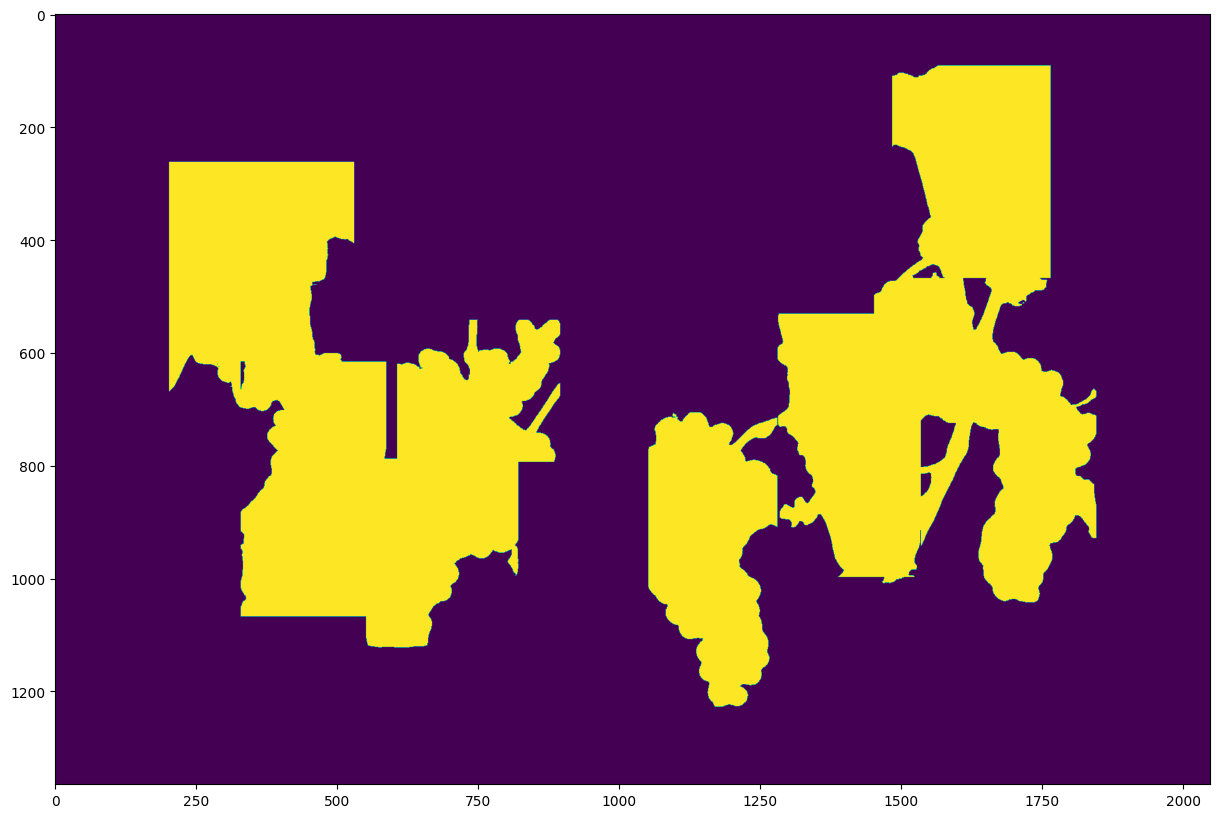

In [50]:
# read npz file
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt


data = np.load('../datasets/ritm_predictions/CSV_1865.jpg_ritm_NoBRS_3_points.npz') 
# for item in data.items():
#         print(f'{key:10s}: {str(item.dtype):20s}:{str(item.shape):20s} -- {item.nbytes:0.2f}B = {item.nbytes/10e6:0.2f}MB;')
# data['arr_0']
plt.imshow(data['arr_0'])